# The Fermi-Pasta-Ulam-Tsingou Problem (2D)

In [159]:
"""
================================================================
        The Fermi-Pasta-Ulam-Tsingou (FPUT) Problem (1D)
================================================================
"""
from math import log10
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as PI
import os
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist

#   Improve performance by applying 'jit' decorator
from numba import jit

__version__ = '1.0'

#   Color-friendly colors!
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = CB_color_cycle)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", CB_color_cycle)
del CB_color_cycle


In [160]:
################################################################################
#                                                                              #
#                            CONSTANTS & PARAMETERS                            #
#                                                                              #
################################################################################

N, ALPHA, BETA, N_MODES, config_str, dt, time_points, y0_amp = (None,) * 8

def init_constants(mN = 2 ** 5, mALPHA = 1.0, mBETA = 1e-1, mN_MODES = 3, mt_max = 1e5, mdt_mantissa = 2.5, mdt_exp = -2):
    """
    Initializes constants and parameters;
    if new simulation conditions are required, pass in values for said values (else default values will be used)

    :param  mN:             parameter N
    :param  mALPHA:         parameter ALPHA
    :param  mBETA:          parameter BETA
    :param  mN_MODES:       parameter N_MODES
    :param  mt_max:         parameter mt_max

    :param  dt_mantissa:    Mantissa of dt (float)
    :param  dt_exp:         Exponent of dt (int)
    """
    global N, ALPHA, BETA, N_MODES, config_str, dt, time_points, y0_amp

    N = mN                                          #   Number of masses

    ALPHA = mALPHA                                  #   Linear spring constant
    BETA = mBETA                                    #   Nonlinear spring constant

    N_MODES = mN_MODES                              #   Number of initial modes

    t_max = mt_max                                  #   Maximum time

    config_str = f"{int(N)}_{str(ALPHA).replace('.', "d")}_{str(BETA).replace('.', "d")}_{int(N_MODES)}"
    config_str += f"_{int(log10(t_max))}_{str(mdt_mantissa).replace('.', "d")}({int(mdt_exp)})"

    dt = mdt_mantissa * 10 ** mdt_exp                 #   Time step
    
    num_steps = int(np.ceil(t_max / dt)) + 1        #   Number of time steps
    time_points = np.linspace(0, t_max, num_steps)
    y0_amp = 1.0                                    #   Initial displacement amplitude
                                                    #   for the first and last points
                                                    #   Chosen as 1 for normalized outputs
    
    #   Create subfolders if missing
    os.makedirs(f'./{config_str}', exist_ok = True)
    os.makedirs('./subset_data', exist_ok = True)
    os.makedirs('./subset_data/time_points', exist_ok = True)

    return None

init_constants()


In [161]:
#   ANIMATION PARAMETERS
frame_step = None

def set_frame_step(total_frames, duration, fps = 60):
    global frame_step

    if total_frames // (duration * fps) == 0:
        frame_step = 1
    else:
        frame_step = total_frames // (duration * fps)          #   To ensure the GIF has 14400 frames

    #   Assuming N = 64 for duration...
    #   FOR     1e3 frames set 30 for non-rotating
    #   FOR     1e3 frames set 45 for rotating
    #   FOR     1e4 frames set 240 for non-rotating
        
    return None
        
set_frame_step(len(time_points), 300)


In [162]:
@jit
def convert_to_cartesian(spherical_coords):
    phi, theta = spherical_coords.T

    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)

    points = np.vstack((x, y, z)).T             #   Convert 3 arrays into 2D array
                                                #   with 3 columns to each array
    return points


## 2-Dimensional

First we need to generate evenly spaced out points on a sphere

### Fibonacci Sphere method
The Fibonacci Sphere algorithm is a method for distributing points uniformly across the surface of a sphere. It's inspired by the Fibonacci sequence and the golden angle. Unlike more regular distributions, like those based on latitude and longitude lines, the Fibonacci Sphere algorithm does not create poles or clustering, providing a more even distribution

The algorithm is based on the concept of the golden ratio and its associated golden angle, which is approximately $137.507764^{\circ}$ (or $\pi\left(3 - \sqrt{5}\right)$, in radians). The golden angle is the angle subtended at the center of a circle by two points on the circumference that divide the circle into a section with the golden ratio. When applied to the sphere distribution, this helps to space points out in an optimal way that minimizes clumping

The key steps of generating points on a sphere using the Fibonacci method are:
1. **Create a Sequence of Indices**: A sequence `i` of `n` numbers is generated, spaced evenly between `0.5` and `n - 0.5`. These indices represent each point to be placed on the sphere
2. **Calculate Azimuthal Angle `θ`**: For each index `i`, an azimuthal angle `θ` is calculated as `θ = golden_angle * i`. This angle spirals around the sphere, ensuring points do not align vertically or horizontally
3. **Calculate Polar Angle `φ`**: The polar angle `φ` is calculated for each point as `φ = arccos(1 - 2 * i / n)`. This determines the elevation of each point above the equatorial plane of the sphere
4. **Convert to Cartesian Coordinates**: Once the spherical coordinates are determined, they can be converted to Cartesian coordinates `[x, y, z]` using the standard conversion formulas for spherical to Cartesian coordinates

In [163]:
@jit
def generate_fibonacci_sphere_points(n):
    """
    Generates points using Fibonacci Sphere method on a sphere of radius 1
    https://www.designcoding.net/fibonacci-sphere/

    :param  n:      number of points
    
    :return points: 2D numpy array of spherical coordinates [theta, phi] of each points
    """
    i = np.linspace(0.5, n - 0.5, n)            #   Evenly spaced sequence
                                                #   between 0.5 and n - 0.5
    golden_angle = PI * (3 - np.sqrt(5))

    theta = golden_angle * i
    phi = np.arccos(1 - 2 * i / n)

    points = np.vstack((theta, phi)).T          #   Convert 3 arrays into 2D array
                                                #   with 2 columns to each array
    return points

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

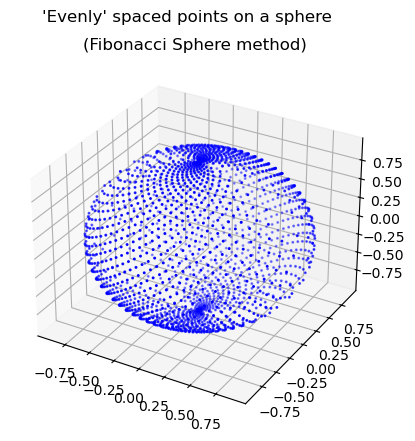

In [164]:
fib_points = convert_to_cartesian(generate_fibonacci_sphere_points(2048))

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(fib_points[:, 0], fib_points[:, 1], fib_points[:, 2], c = 'b', marker = '.', s = 5)

#   Set plot limits and labels
x_max = np.max(fib_points[:, 0])
y_max = np.max(fib_points[:, 1])
z_max = np.max(fib_points[:, 2])
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.set_zlim(-z_max, z_max)
ax.set_title('(Fibonacci Sphere method)')
fig.suptitle("'Evenly' spaced points on a sphere")
plt.show()


### Electrostatic repulsion method
The electrostatic repulsion method is a technique used to distribute points on surfaces, commonly on spheres, such that they are as evenly spaced as possible. This method simulates the repulsive force experienced by charged particles that follow Coulomb's Law, where like charges repel each other. By treating each point as if it carries an equal positive charge, the algorithm distributes them in a way that minimizes the overall potential energy of the system, leading to an even spacing. Imagine each point on the surface as a positively charged particle. When these particles are placed on a sphere, they will move to maximize their distances from each other due to the repulsive electrostatic force. The equilibrium state, where the forces are balanced, represents the solution to the problem of distributing points evenly
1. **Initialization**: Place points randomly on the surface
2. **Force Calculation**: For each point, calculate the net electrostatic repulsive force exerted by all other points
3. **Movement**: Move each point along the direction of the resultant force, proportionally to the magnitude of the force and a chosen step size
4. **Convergence**: Repeat the force calculation and movement steps until the system converges to a stable state, where points no longer move significantly
5. **Projection**: After each iteration, project points back onto the surface to maintain the constraint of staying on the surface

In [165]:
def initial_positions(n):
    """
    Generates n random points on a sphere of radius 1

    :param  n:      number of points

    :return points: 2D numpy array of coordinates [x, y, z] of each points
    """
    coords = np.random.randn(n, 3)
    norms = np.linalg.norm(coords, axis = 1).reshape(-1, 1)
    
    return coords / norms

def repulsive_forces(points, epsilon):
    """
    Compute forces acting on each point

    :param  points:     2D numpy array of coordinates [x, y, z] of each points
    :param  epsilon:    tolerance for pairwise distance to prevent divide by zero -> NaN

    :return forces:     force vectors acting on each point
    """
    pairwise_distances = cdist(points, points, 'euclidean')
    np.fill_diagonal(pairwise_distances, np.inf)            #   Prevent division by zero
                                                            #   in force calculations
    # Calculate repulsive force magnitude (inverse square law)
    force_magnitudes = 1.0 / (pairwise_distances ** 2 + epsilon ** 2)
    
    # Calculate direction vectors for all pairs
    direction_vectors = points[:, np.newaxis, :] - points[np.newaxis, :, :]
    
    # Normalize direction vectors to unit vectors
    norms = np.linalg.norm(direction_vectors, axis = 2, keepdims = True)
    norms = np.where(norms == 0, np.inf, norms)             #   Avoid division by zero by
                                                            #   replacing 0 with inf
    unit_direction_vectors = direction_vectors / norms
    
    # Calculate forces as vectors
    forces = np.sum(force_magnitudes[:, :, np.newaxis] * unit_direction_vectors, axis = 1)
    
    return forces

def electrostatic_simulate(points, iterations, learning_rate, epsilon, convergence_threshold):
    """
    Simulates time evolution of electrostatic repulsion

    :param  points:                 numpy array of coordinates [x, y, z] of each points
    :param  iterations:             loop count
    :param  learning_rate:          time step
    :param  epsilon:                tolerance for pairwise distance to prevent divide by zero -> NaN
    :param  convergence_threshold:  loop termination condition

    :return points:                 final numpy array of coordinates [x, y, z] of each points
    """
    for i in range(iterations):
        forces = repulsive_forces(points, epsilon)
        delta_points = forces * learning_rate
        points += delta_points
        norms = np.linalg.norm(points, axis = 1).reshape(-1, 1)
        points = points / norms
        
        # Dynamic learning rate adjustment
        if i % 100 == 99:           #   Adjust the learning rate every 100 iterations
            learning_rate *= 0.9    #   Reduce the learning rate to stabilize convergence
        
        # Check for convergence
        max_movement = np.max(np.linalg.norm(delta_points, axis = 1))
        if max_movement < convergence_threshold:
            print(f"Converged after {i + 1} iterations")
            break
    
    return points

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

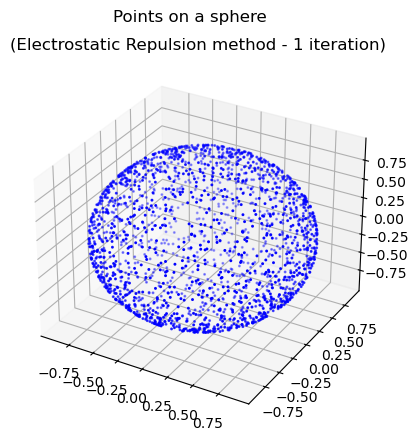

In [166]:
init_points = initial_positions(2048)
first_points = electrostatic_simulate(init_points, 1, 1e-4, 1e-32, 1e-7)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(first_points[:, 0], first_points[:, 1], first_points[:, 2], c = 'b', marker = '.', s = 5)

#   Set plot limits and labels
x_max = np.max(first_points[:, 0])
y_max = np.max(first_points[:, 1])
z_max = np.max(first_points[:, 2])
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.set_zlim(-z_max, z_max)
ax.set_title('(Electrostatic Repulsion method - 1 iteration)')
fig.suptitle('Points on a sphere')
plt.show()


In [167]:
# final_points = electrostatic_simulate(init_points, 100000, 1e-4, 1e-32, 1e-7)

# np.savetxt(f'./2D_sphere_points.txt', final_points)

final_points = np.loadtxt("./2D_sphere_points.txt")

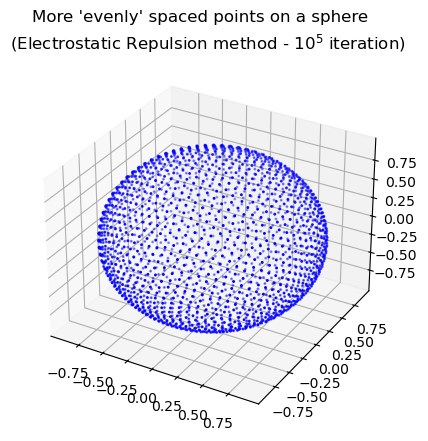

In [168]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(final_points[:, 0], final_points[:, 1], final_points[:, 2], c = 'b', marker = '.', s = 5)

#   Set plot limits and labels
x_max = np.max(final_points[:, 0])
y_max = np.max(final_points[:, 1])
z_max = np.max(final_points[:, 2])
ax.set_xlim(-x_max, x_max)
ax.set_ylim(-y_max, y_max)
ax.set_zlim(-z_max, z_max)
ax.set_title(r'(Electrostatic Repulsion method - $10^5$ iteration)')
fig.suptitle("More 'evenly' spaced points on a sphere")
plt.show()


### Pairwise distance analysis

In [169]:
def find_closest_neighbors(points, k):
    """
    Finds the k closest neighbors for each point in the dataset

    :param  points:     numpy array of coordinates [x, y, z] of each points
    :param  k:          number of close neighbors to search
    :return indices:    ordered numpy array indices of closest neighbors
    :return distances:  ordered numpy array distances of closest neighbors
    """
    tree = cKDTree(points)          #   Query the k+1 nearest neighbors for each point because
                                    #   the query includes the point itself in the results.
    distances, indices = tree.query(points, k = k + 1)
    
    # Exclude the point itself from its list of closest neighbors
    return indices[:, 1:], distances[:, 1:]

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [170]:
def compare_closest_neighbors():
    n_neighbors = len(final_points) - 1
    neighbors_indices, neighbors_distances = find_closest_neighbors(final_points, n_neighbors)

    low_bin = neighbors_distances[neighbors_distances <= 0.1]

    mid_bin = neighbors_distances[neighbors_distances >= 0.1]
    mid_bin = mid_bin[mid_bin <= 0.125]

    high_bin = neighbors_distances[neighbors_distances >= 0.125]
    high_bin = high_bin[high_bin <= 0.2]

    print(f'Pairwise difference lower than 0.1 units:           {len(low_bin)}')
    print(f'Pairwise difference between 0.1 and 0.125 units:    {len(mid_bin)}')
    print(f'Pairwise difference between 0.125 and 0.2 units:    {len(high_bin)}')

    plt.hist(neighbors_distances[neighbors_distances <= 0.40], bins = 50, color = 'b', edgecolor = 'black')
    plt.title(r'Histogram of Neighbor distances ($\Delta d\leq 0.40$)')
    plt.xlabel('Distance between neighbors')
    plt.ylabel('Count')
    plt.show()
    plt.close()

    plt.hist(neighbors_distances.flatten(), bins = 100, color = 'b', edgecolor = 'black')
    plt.title('Histogram of Neighbor distances (ALL)')
    plt.xlabel('Distance between neighbors')
    plt.ylabel('Count')
    plt.show()
    plt.close()


Pairwise difference lower than 0.1 units:           12090
Pairwise difference between 0.1 and 0.125 units:    330
Pairwise difference between 0.125 and 0.2 units:    24754


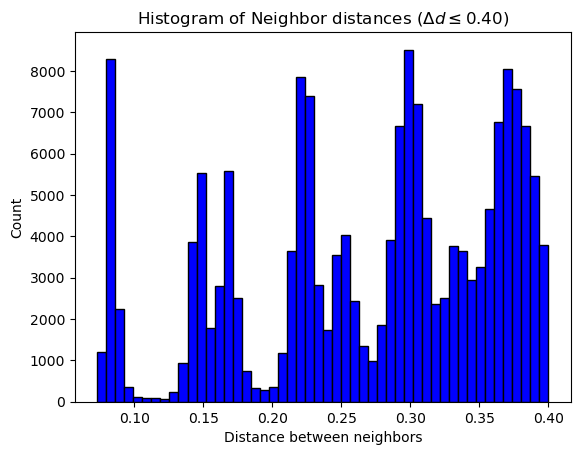

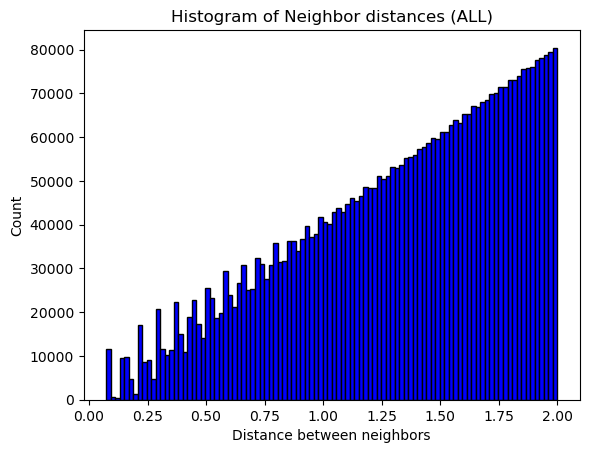

In [171]:
compare_closest_neighbors()

From this we can see clear clusters of 'concentric' points around an arbitrary point. Thus, we can treat points at the closest cluster $< 0.1$ units away as immediate 'neighboring' points

In [172]:
def twoD_fixed(y, v):
    """
    Adjusted to include boundary particles' interactions.
    """
    dvdt = np.zeros_like(y)
    
    # Include all particles, adjusting for boundaries
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            # Neighbors' displacements, using conditional expressions for boundaries
            y_up = y[i+1, j] if i < y.shape[0] - 1 else 0
            y_down = y[i-1, j] if i > 0 else 0
            y_right = y[i, j+1] if j < y.shape[1] - 1 else 0
            y_left = y[i, j-1] if j > 0 else 0
            
            # Linear term
            linear_term = ALPHA * (y_up + y_down + y_right + y_left - 4 * y[i, j])

            # Nonlinear term
            nonlinear_term = BETA * (
                (y_up - y[i, j])**2 - (y[i, j] - y_down)**2 +
                (y_right - y[i, j])**2 - (y[i, j] - y_left)**2
            )

            dvdt[i, j] = linear_term + nonlinear_term
    
    return v, dvdt


In [173]:
import numpy as np

def twoD_fixed_optimized(y, v):
    ALPHA, BETA = 1.0, 0.1  # Assuming these are defined globally or passed as parameters

    # Create padded version of y for boundary conditions
    padded_y = np.pad(y, ((1, 1), (1, 1)), mode='constant', constant_values=0)

    # Precompute shifted versions of y for all four directions
    y_up = padded_y[:-2, 1:-1]
    y_down = padded_y[2:, 1:-1]
    y_left = padded_y[1:-1, :-2]
    y_right = padded_y[1:-1, 2:]

    # Calculate linear and nonlinear terms using NumPy's vectorized operations
    linear_term = ALPHA * (y_up + y_down + y_left + y_right - 4 * y)
    nonlinear_term = BETA * ((y_up - y)**2 + (y_down - y)**2 + (y_left - y)**2 + (y_right - y)**2)

    # The overall acceleration (dv/dt)
    dvdt = linear_term + nonlinear_term

    return v, dvdt


In [174]:
#   Runge-Kutta 4th order method
def rk4_step(y, v, dt, func):
    """
    Runge-Kutta 4th order ODE Solver
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    :param  dt:     timestep
    :param  func:   ODE expression

    :return y_next: numpy array of successive y values
    :return v_next: numpy array of successive v values
    """
    k1_y, k1_v = func(y, v)
    k2_y, k2_v = func(y + dt / 2 * k1_y, v + dt / 2 * k1_v)
    k3_y, k3_v = func(y + dt / 2 * k2_y, v + dt / 2 * k2_v)
    k4_y, k4_v = func(y + dt * k3_y, v + dt * k3_v)
    
    y_next = y + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    v_next = v + dt / 6 * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
    
    return y_next, v_next


In [175]:
def initialize_2d_mode(Nx, Ny, mode_x, mode_y, amplitude=1.0):
    """
    Initialize the 2D system for mode excitation.

    Parameters:
    Nx, Ny: Grid size in the x and y dimensions.
    mode_x, mode_y: Mode numbers in the x and y dimensions.
    amplitude: Amplitude of the excitation.

    Returns:
    y: 2D array of displacements.
    v: 2D array of velocities (initialized to zero).
    """
    # Create a grid of points
    x = np.linspace(0, 1, Nx, endpoint=False)
    y = np.linspace(0, 1, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y)
    
    # Initialize displacements as a 2D sine wave in the specified mode
    displacements = amplitude * np.sin(mode_x * np.pi * X) * np.sin(mode_y * np.pi * Y)
    
    # Initialize velocities to zero
    velocities = np.zeros((Ny, Nx))
    
    return displacements, velocities


In [176]:
def twoD_simulator(ode_solver, init_func, mode_x, mode_y, expression, Nx, Ny):
    """
    Simulates time evolution of oscillators in 2D.

    Parameters:
    ode_solver: ODE Solving algorithm (adapted for 2D).
    init_func: Function to initialize displacements and velocities.
    mode_x, mode_y: Mode numbers for initialization in x and y dimensions.
    expression: Function calculating accelerations (forces) on each particle.
    Nx, Ny: Number of particles in the x and y dimensions.
    dt: Time step size.
    t_max: Maximum simulation time.

    Returns:
    displacements: 3D array of displacements for each timestep (time, y, x).
    velocities: 3D array of velocities for each timestep (time, y, x).
    """
    # Initialize displacements and velocities
    displacements, velocities = init_func(Nx, Ny, mode_x, mode_y)

    # Initialize arrays to store time evolution data
    displacements_evolution = np.zeros((len(time_points), Ny, Nx))
    velocities_evolution = np.zeros((len(time_points), Ny, Nx))

    # Store initial conditions
    displacements_evolution[0, :, :] = displacements
    velocities_evolution[0, :, :] = velocities

    # Time evolution
    for step in range(1, len(time_points)):
        displacements, velocities = ode_solver(displacements, velocities, dt, expression)
        displacements_evolution[step, :, :] = displacements
        velocities_evolution[step, :, :] = velocities

    return displacements_evolution, velocities_evolution


In [177]:
init_constants(mt_max = 2.5e3)
displacements_evolution, velocities_evolution = twoD_simulator(
    rk4_step,
    initialize_2d_mode,
    3, 2,
    twoD_fixed,
    10, 10
)


In [ ]:
def gif_plotter_3d(fn, displacements_evolution, Nx, Ny):
    """
    Animation Plotter function for 3D visualization.

    Parameters:
    fn: Filename for saving the animation.
    displacements_evolution: 3D array of displacements over time (time, y, x).
    Nx, Ny: Dimensions of the 2D grid.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Generate grid indices for particle positions
    x, y = np.meshgrid(range(Nx), range(Ny))
    x = x.flatten()
    y = y.flatten()
    
    # Initial plot
    z = displacements_evolution[0].flatten()
    scatter = ax.scatter(x, y, z, c='b', marker='.')

    # Set plot limits and labels
    max_disp = np.max(displacements_evolution)
    ax.set_zlim(-max_disp, max_disp)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Displacement')
    title = ax.set_title(f'Time: {0:.3f} units')

    # Update function for animation
    def update(frame):
        z_new = displacements_evolution[frame].flatten()
        scatter._offsets3d = (x, y, z_new)  # Update the positions of the points
        title.set_text(f'Time: {frame * dt:.3f} units')
        return scatter,

    # Create and save the animation
    ani = FuncAnimation(fig, update, frames=range(0, len(displacements_evolution), frame_step), blit=False)
    ani.save(f'./{config_str}/{fn}_{config_str}_2D.mp4', writer = 'ffmpeg', fps = 60)

    plt.close()
    return None


In [ ]:
gif_plotter_3d('displacements_1D_periodic', displacements_evolution, 10, 10)